# Tarea 1 - Introducción a Data Science

Integrantes:
- Axel Mondaca
- Sebastián Hernández

### Instalación de librerías

Se instalan las librerías necesarías para el funcionamiento correcto del código.

In [ ]:
%pip install selenium
%pip install pandas
%pip install matplotlib

### Importar librerías

In [ ]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import matplotlib.pyplot as plt
import math

### Código

In [ ]:
base_url = "https://nextspaceflight.com/launches/past/" #Indicamos el sitio web
last_page = 240 #Indicamos el total de páginas

In [45]:
options = Options()
options.add_argument("--headless")
browser = webdriver.Chrome(options=options)
browser.get(base_url)

browser2 = webdriver.Chrome(options=options)
#Obtención de datos
launch_data = []
for page in range(1, last_page):  
    browser.get(f"{base_url}?page={page}") # obtenemos el html (hace la petición), sin selenium sería la librería de requests
    cards = browser.find_elements(By.CLASS_NAME, "mdl-card")
    
    # Lectura de las cartas
    for card in cards:
        company = card.find_element(By.CLASS_NAME, "mdl-card__title-text").text
        rocket_and_payload = card.find_element(By.CLASS_NAME, "header-style").text
        date_and_location = card.find_element(By.CLASS_NAME, "mdl-card__supporting-text").text.replace(",", "").replace("CLST", "").replace("CLT", "").replace("GMT-4", "")
        details_url = card.find_element(By.CLASS_NAME, "mdc-button").get_attribute("href")
        style = card.get_attribute("style")
        total_payload = 0
        rocket_height = 0
        fairing_diameter = 0
        fairing_height = 0
        price = 0
        volume = 0
        success = "Desconocido"
        color = card.get_attribute("style").split("border-color:")[1].split(";")[0].strip().lower()
        
        #Navegamos a la página de detalles
        browser2.get(details_url)
        
        try: 
            sections = browser2.find_elements(By.CLASS_NAME, "mdl-card__supporting-text")
            for section in sections:
                elements = section.find_elements(By.CLASS_NAME, "mdl-cell")
                for element in elements:
                    #Calculamos el total payload
                    text = element.text.strip()
                    if "Payload to LEO" in text:
                        number = int(text.split(":")[1].replace(",", "").replace(" kg", "").strip())
                        total_payload += number
                    elif "Payload to GTO" in text:
                        number = int(text.split(":")[1].replace(",", "").replace(" kg", "").strip())
                        total_payload += number
                    
                    #Calculamos la altura del cohete y el diámetro y altura de la cofia
                    elif "Rocket Height" in text:
                        number = float(text.split(":")[1].replace("m", "").strip())
                        rocket_height += number
                    elif "Fairing Diameter" in text:
                        number = float(text.split(":")[1].replace("m", "").strip())
                        fairing_diameter += number
                    elif "Fairing Height" in text:
                        number = float(text.split(":")[1].replace("m", "").strip())
                        fairing_height += number
                        
                    #Obtenermos el precio
                    elif "Price" in text:
                        number = float(text.split(":")[1].replace(",", "").replace("$", "").replace("million", "").strip())
                        price += number
        except Exception as e:
            print(f"Error al obtener detalles de la URL {details_url}: {e}")
        
        # Determinamos si el lanzamiento fue exitoso, fallido o parcialmente fallido
        if color == "rgb(69, 207, 93)":
            success = "Success"
        elif color == "rgb(218, 52, 50)":
            success = "Failed"
        else:
            success = "Partial Failure"
            
    # Creamos el diccionario con los datos obtenidos
        launch_dict = {'company': company, 
                    'rocket_and_payload': rocket_and_payload, 
                    'date_and_location': date_and_location, 
                    'details_url': details_url,
                    'total_payload': total_payload,
                    'fairing_diameter': fairing_diameter,
                    'fairing_height': fairing_height,
                    'rocket_height': rocket_height,
                    'price': price,
                    'volume': volume,
                    'success': success}

        launch_data.append(launch_dict)


browser.quit()
browser2.quit()

# Crear DataFrame
df = pd.DataFrame(launch_data, columns=['company', 'rocket_and_payload', 'date_and_location', 'details_url',
                                        'total_payload', 'fairing_diameter', 'fairing_height', 'rocket_height',
                                        'price','volume','success'])
df.size
df.shape



(7170, 11)

# Función para establecer el formato de la fecha


In [46]:
def clean_date(scraped_date_string):
    months = { "Jan":"01", "Feb":"02", "Mar":"03", "Apr":"04", "May":"05", "Jun":"06",
               "Jul":"07", "Aug":"08", "Sep":"09", "Oct":"10", "Nov":"11", "Dec":"12" }
    parts = scraped_date_string.split(" ")
    month = months[parts[1]]
    day = parts[2].replace(",", "")
    year = parts[3]
    return f"{year}/{month}/{day}"

# Normalización de los datos

En esta sección nos aseguramos que el data frame no tenga ruido en los datos y los formateamos según el uso que se le quiere entregar.

In [47]:
#Separación de columnas y limpieza de datos
df["rocket"] = df["rocket_and_payload"].str.split("|").str[0]
df["payload"] = df["rocket_and_payload"].str.split("|").str[1]
df["date"] = df["date_and_location"].str.split("\n").str[0]
df["location"] = df["date_and_location"].str.split("\n").str[1]
# Eliminamos las columnas que ya no son necesarias
df.drop(columns=["rocket_and_payload", "date_and_location"], inplace=True)

#Calculamos el volumen de la cofia y del cohete
mean_height = df.loc[df["fairing_height"] != 0.0, "fairing_height"].mean().round(2)
df.loc[df["fairing_height"] == 0.0, "fairing_height"] = mean_height
df["volume"] = (1/3) * math.pi * (df["fairing_diameter"]/2)**2 * df["fairing_height"] + math.pi * (df["fairing_diameter"]/2)**2 * df["rocket_height"]
df["volume"] = df["volume"].round(2)

#Calculamos el precio medio y reemplazamos los valores 0.0 por la media
mean_price = df.loc[df["price"] != 0.0, "price"].mean().round(2)
df.loc[df["price"] == 0.0, "price"] = mean_price
# Limpiamos la columna de fecha
df["date"] = df["date"].apply(clean_date)



df
# Exportar a CSV
df.to_csv('launch_data.csv', index=False)

# Carga enviada exitosamente al espacio por empresa

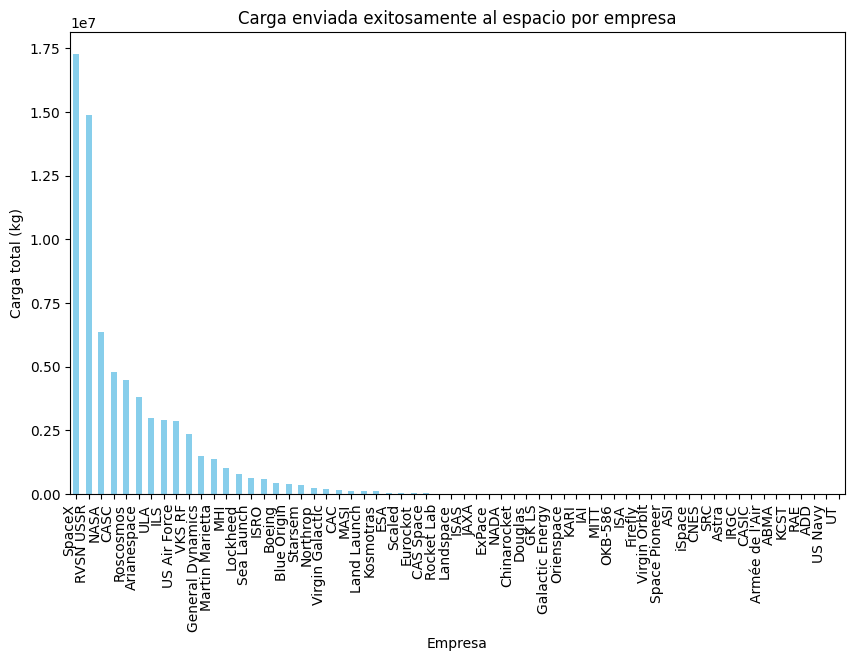

In [ ]:
df_success = df[df["success"] == "Success"]

pd

mean_payload = df.loc[df["total_payload"] != 0, "total_payload"].mean().round(2)

# Rellenamos los datos de carga con el promedio de valores donde sean igual a 0
df["total_payload"] = df["total_payload"].astype(float)
df.loc[df["total_payload"] == 0, "total_payload"] = mean_payload
df.to_csv('launch_data.csv', index=False)

# Rellenamos los datos de volumen con el promedio de valores donde sean igual a 0
mean_volume = df.loc[df["volume"] != 0, "volume"].mean().round(2)
df["volume"] = df["volume"].astype(float)
df.loc[df["volume"] == 0, "volume"] = mean_volume
df.to_csv('launch_data.csv', index=False)

# Agrupar por empresa
payload_by_company = df_success.groupby("company")["total_payload"].sum().sort_values(ascending=False)

# Graficamos
plt.figure(figsize=(10,6))
payload_by_company.plot(kind="bar", color="skyblue")
plt.title("Carga enviada exitosamente al espacio por empresa")
plt.ylabel("Carga total (kg)")
plt.xlabel("Empresa")
plt.xticks(rotation=90, ha="right")
plt.show()

Las 2 empresas que han mandado la mayor cantidad de cargas exitosas al espacio son **SpaceX y RVSN USSR**

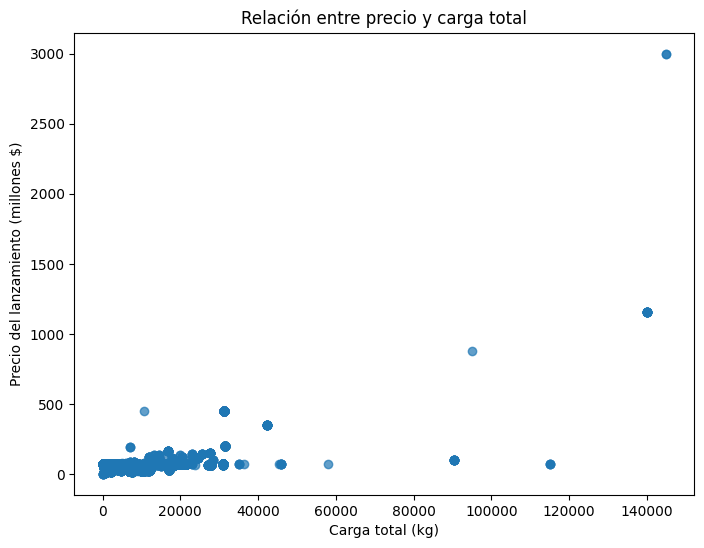

In [58]:
plt.figure(figsize=(8,6))
plt.scatter(df["total_payload"], df["price"], alpha=0.7)
plt.title("Relación entre precio y carga total")
plt.xlabel("Carga total (kg)")
plt.ylabel("Precio del lanzamiento (millones $)")
plt.show()

Haciendo una exploración inicial de los datos y la relación entre las variables, podemos visualizar que existe una relación entre la carga total en kilogramos y el precio en donde la carga total menor está relacionada de manera directa con el precio del lanzamiento.

# Volumen de cohetes por empresa

Text(0.5, 1.0, 'Volumen de cohetes por empresa')

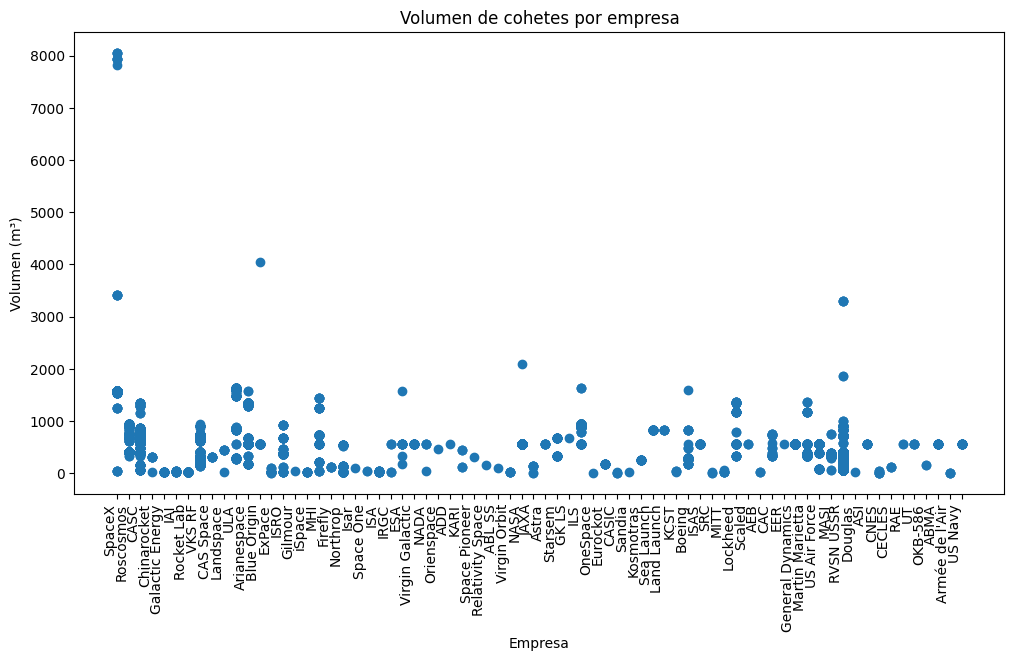

In [61]:
plt.figure(figsize=(12,6))
plt.scatter(df['company'],df['volume'])
plt.xticks(rotation=90,ha='right')
plt.xlabel('Empresa')
plt.ylabel('Volumen (m³)')
plt.title('Volumen de cohetes por empresa')

La empresa que lanza los cohetes con mayor volumen es SpaceX, seguido de Blue Origin y RVSN USSR en segundo y tercer lugar respectivamente.

# Volumen de cohetes por lanzamientos exitosos, no exitosos y con falla parcial

Text(0.5, 1.0, 'Volumen de cohetes por lanzamientos exitosos y no exitosos')

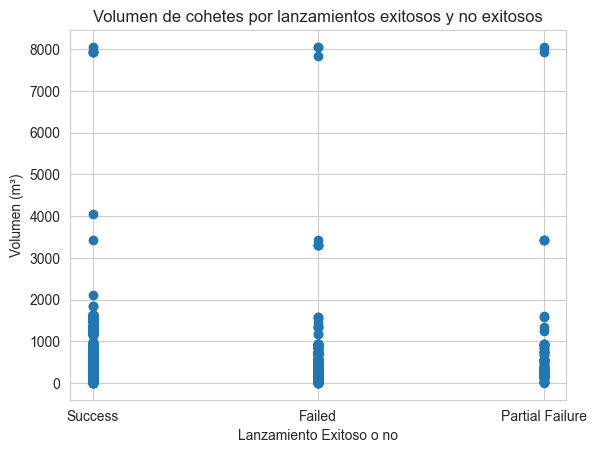

In [ ]:
plt.scatter(df['success'],df['volume'])
plt.xlabel('Lanzamiento Exitoso o no')
plt.ylabel('Volumen (m³)')
plt.title('Volumen de cohetes por lanzamientos exitosos, no exitosos y con falla parcial')

Los volúmenes de los cohetes se distribuyen de manera no simétrica con la mayoría de los valores centrándose en el intervalo entre 0 y 2000 metros cúbicos de volumen.

# Evolución de lanzamientos de cohetes por país anualmente

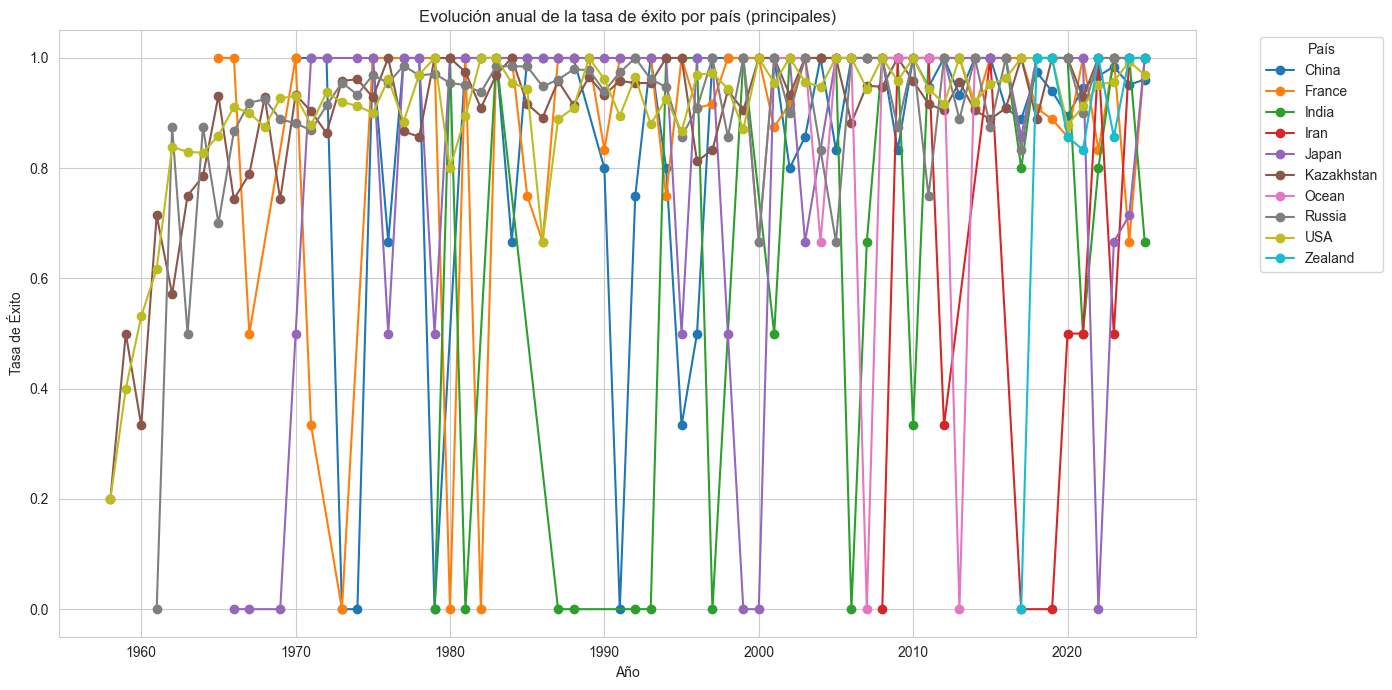

In [77]:
# Extraemos los años
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year

# Extraemos el país desde la columna location
df["country"] = df["location"].apply(lambda x: str(x).split()[-1])

# 3. Creamos una nueva variable que indica si fue exitoso o no el lanzamiento
df["success_flag"] = df["success"].apply(lambda x: 1 if x == "Success" else 0)

# Agrupamos por país y año
summary = df.groupby(["country", "year"]).agg(
    total_launches=("success", "count"),
    successful_launches=("success_flag", "sum")
).reset_index()

# Calculamos la tasa de éxito
summary["success_rate"] = summary["successful_launches"] / summary["total_launches"]

# Mostramos solo los países con más de 20 lanzamientos en total para evitar saturar el gráfico
country_counts = summary.groupby('country')["total_launches"].sum()
top_countries = country_counts[country_counts > 20].index
filtered_summary = summary[summary['country'].isin(top_countries)]

# 6. Graficar: histograma de tasa de éxito anual por país (solo países principales)
plt.figure(figsize=(14,7))

for i, country in enumerate(filtered_summary["country"].unique()):
    data = filtered_summary[filtered_summary["country"] == country]
    plt.plot(data["year"], data["success_rate"], marker='o', label=country)

plt.xlabel("Año")
plt.ylabel("Tasa de Éxito")
plt.title("Evolución anual de la tasa de éxito por país (principales)")
plt.legend(title="País", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Con el fin de no saturar el gráfico, redujimos los datos a los países que hicieron más de 20 lanzamientos de cohetes por año.

Analizando los datos, podemos ver que en general la tasa de éxitos por país ha aumentado considerablemente con los años, con la mayoría de los países involucrados manteniéndose una tasa de éxito por sobre el 80% desde la década de 1970 y manteniéndose de aquella manera hasta el presente.